# CS585 Homework 2: Word2Vec

#### This is due on October 12, 2018, submitted electronically. 100 points total.

In this homework, you will complete the following tasks: 
1. implement the objective function and parameter updates for word2vec's skipgram with negative sampling (SGNS) algorithm. 
2. answer questions about the training process and produce a visualization of some pretrained word embeddings

##### How to do this problem set:

- What version of Python should I use? Either Python 2 or 3 should work

- Most of these questions require writing Python code and computing results, and the rest of them have textual answers. To generate the answers, you will have to fill out a supporting file, `word2vec.py`.

- For all of the textual answers you have to fill out have placeholder text which says "Write your answer here" For each question, you need to replace "Write your answer here" with your answer.

- Write all the answers in this ipython notebook. Once you are finished (1) Generate a PDF via (File -> Download As -> PDF) and upload to Gradescope (2) Turn in `word2vec.py` and `homework_2.ipynb` on Moodle.
  
- **Important** check your PDF before you turn it in to gradescope to make sure it exported correctly. If ipython notebook gets confused about your syntax it will sometimes terminate the PDF creation routine early. If your whole PDF does not print, try running `$jupyter nbconvert --to pdf 2018hw2.ipynb` to identify and fix any syntax errors that might be causing problems

- When creating your final version of the PDF to hand in, please do a fresh restart and execute every cell in order. Then you'll be sure it's actually right. One handy way to do this is by clicking `Cell -> Run All` in the notebook menu.
 
- This assignment is designed so that you can run all cells in a few minutes of computation time. If it is taking longer than that, you probably have made a mistake in your code.

##### Academic honesty 

- We will audit the Moodle code from a set number of students, chosen at random. The audits will check that the code you wrote and turned on Moodle generates the answers you turn in on your PDF. If you turn in correct answers on your PDF without code that actually generates those answers, we will consider this a serious case of cheating. See the course page for honesty policies.

- We will also run automatic checks of code on Moodle for plagiarism. Copying code from others is also considered a serious case of cheating.

## Part 1: toy word2vec (65 points)

Our first task will be to implement SGNS. We'll be working with a small "toy" dataset to ensure that your model works properly before moving on to real text. To start, run the cell below to set up the toy task.

In [72]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from word2vec import *
import numpy as np

# first task: develop a working word2vec model on a toy dataset

# we'll set some simple model hyperparameters...
dim = 5 # dimensionality of word vectors
window_size = 4 # how many total surrounding words to include in context
vocab_size = 10 # number of word types in vocab
vocab = range(vocab_size) # small vocab for developing our model

# now let's initialize our word embedding matrices
W,C = init_parameters(dim, vocab_size)
print(W.shape, C.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(10, 5) (10, 5)


### Question 1.1 (5 pts):
What does each row of W represent? What about each column?


**Each row in the W matrix represents a word type. Since the sample vocab is of 10 word types, the 3rd row in 'W' would represent the one-hot vector of the 3rd word in the sentence. Each column represents our new vector representation of each of these words.**

### Question 1.2 (15 pts): 
The *compute_obj_and_grad* function in *word2vec.py* partially implements the SGNS objective function for a single (target word, context word) pair: $L = \log P(+ | t,c) + \sum_{i=0}^k \log P(- |t, n_i)$. 

You will complete this function by filling in the *compute_pos_prob* and *compute_neg_prob* functions. Specifically, *compute_pos_prob* should compute $P(+ | t,c)$ for a target word vector $t$ and a context word vector $c$, while *compute_neg_prob* should compute $P(- |t, n_i)$ for a negative sample word vector $n_i$ and $c$. 

***IMPORTANT:*** Please do not implement your own sigmoid function! word2vec.py imports scipy's sigmoid function, which you can use simply by typing *sigmoid*, as in ```x = sigmoid(5)```

If you did it correctly, running the cell below will give you a "congratulations" message.

In [73]:
obj_check(compute_obj_and_grad, dim, vocab_size)

running loss check...
congratulations! you've successfully implemented the SGNS objective.


### Question 1.3 (5 pts):
Take a look at the *dW* and *dC* variables in the *compute_obj_and_grad* function, which will eventually contain $\frac{\partial L}{\partial{W}}$ and $\frac{\partial L}{\partial{C}}$, respectively. They are matrices of the same size as W and C. What should each row of *dW* contain? What about each row of *dC*? 

**Each row of dW and dC should contain zeroes initially so that when we backward pass through it for the gradient, it will be clear. **

### Question 1.4 (40 pts): 
Implement the gradient of the SGNS objective by properly updating the *dW* and *dC* variables in the *compute_obj_and_grad* function. You'll need to compute four different partial derivatives, each of which is marked by "IMPLEMENT ME" in the code:
1. derivative of the log P(+ | t, c) term of L WRT target word vector t
2. derivative of the log P(+ | t, c) term of L WRT context word vector c
3. derivative of the log P(- | t, n_i) term of L WRT target word vector t
4. derivative of the log P(- | t, n_i) term of L WRT context word vector n_i

If you do it correctly, you will see a "congratulations" message after running the next cell.

***Hint:*** You may find it convenient to reuse the *pos_prob* and *neg_prob* variables in your derivative computations!

In [74]:
'''
performs a gradient check using a finite differences approximation 
(if interested, see https://en.wikipedia.org/wiki/Finite_difference). 
the function feeds target word 3 and context word 9 as inputs, and 
computes the gradient using words [4,3,2,2] as negative samples. 
if there are any errors in your code, the function will print out which
target and context word derivatives were improperly computed.
''' 
gradient_check(compute_obj_and_grad, W, C, dim, vocab_size)


running gradient check...
congratulations! you've successfully implemented the SGNS gradient.


## Part 2: visualizing word2vec (35 pts)

Now that we have a working SGNS algorithm, we'll first take a look at the training process before moving on to evaluating some pretrained embeddings. Run the next cell to read in a small subset of Wikipedia and reset the model hyperparameters:

In [75]:
# read in the small data file
data_file = 'small_text8'
num_epochs = 3 # number of passes through the dataset to make
text, vocab, sampling_dist = compute_vocab(data_file) 
idx_to_w = dict((v,k) for (k,v) in vocab.items()) # useful for eval / debugging; if you are using Python2, replace vocab.items() by vocab.iteritems()

# onto some real-world model hyperparameters...
dim = 25 # dimensionality of word vectors
window_size = 4 # how many total surrounding words to include in context
vocab_size = len(vocab) # number of word types in vocab

W, C = init_parameters(dim, vocab_size) # new embeddings
print(W.shape, C.shape, len(text))

(52754, 25) (52754, 25) 1000000


### Question 2.1 (5 pts):
You should see that W and C are both of shape (52754, 25), while the *text* variable contains 1000000 tokens from Wikipedia. Now, let's analyze the *sampling_dist* variable, which is a list of words from which negative samples are drawn. Write some code below to print out the top 20 most frequently occurring words in *sampling_dist*. Use the *idx_to_w* dictionary to map from indices to words.

In [76]:
# IMPLEMENT ME!
c= Counter(sampling_dist)
#print (list(c)[:20])
#keys = list(c)
#res = sorted(c, key=lambda x: (-c[x], keys.index(x)))
res=c.most_common(20)
print (res)
for (i,j) in res:
    print(idx_to_w[i])
#for i in res:
#    print(idx_to_w(i)[:20])
    

[(15, 3968), (5, 2656), (19, 2002), (196, 1968), (26, 1837), (3, 1593), (29, 1586), (253, 1311), (275, 1290), (24, 1080), (445, 1071), (2, 824), (311, 822), (254, 769), (147, 756), (47, 748), (446, 736), (344, 732), (33, 727), (315, 719)]
the
of
and
one
in
a
to
zero
nine
is
two
as
eight
three
was
by
five
s
that
for


### Question 2.2 (5 pts):
Your list should be dominated by common words (e.g., "the", "and", "of"). Why is this expected? 

**These sort of words are conjunction words and occur very often in english grammar and are needed to connect sentences. However, it is difficult to gain accurate context similarity from these words since they can occur alongside almost anything and hence, are the most frequent words in the negative sampling.**

### Question 2.3 (5 pts):
Examine the *train* function in word2vec.py. Is it performing gradient ascent or descent? How can you tell? 

**Gradient Descent since we are trying to minimize the loss function**

Unfortunately, this implementation of SGNS is horribly slow and will take days to converge even on this tiny dataset :( Google's implementation is in highly-optimized C (https://github.com/dav/word2vec/blob/master/src/word2vec.c). Instead of making you train your own embeddings, we'll take a look at some pretrained word embeddings! Run the below cell to load 50-d GloVe embeddings for every word in our vocabulary. This should take a couple of seconds.

In [77]:
W = load_embeddings('glove.6B.50d.txt', vocab, idx_to_w)
print('loaded pretrained embeddings of shape %s' % repr(W.shape))

loaded pretrained embeddings of shape (52754, 50)


### Question 2.4 (5 pts):
Now let's examine the learned embeddings using nearest neighbors. We have provided you an efficient function that prints nearest neighbors using cosine distance. First run the below cell to identify the nearest neighbors of the words *baseball* and *bad*.

In [78]:
nearest_neighbors('baseball', vocab, idx_to_w, W)
nearest_neighbors('bad', vocab, idx_to_w, W)

baseball :
basketball 0.8613374075133903
nba 0.8525449364066786
nfl 0.8311337584283504
football 0.7990507449559058
leagues 0.7907130952435445
cowboys 0.7906256216634389
hockey 0.7874407530957857
yankees 0.7764779018352768
yankee 0.7724197498247807

bad :
worse 0.8878378596399723
unfortunately 0.865050096076969
too 0.8608258507491716
really 0.8486315454065445
little 0.8427671435087242
bit 0.8359227625820689
things 0.830611710077923
nothing 0.8246172635059479
gone 0.8238306951162726



Now provide the part-of-speech tag(s) for each of the 10 nearest neighbors of *bad* using the Penn Treebank POS tagset (https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html). Additionally, which of *bad*'s nearest neighbors do you think shouldn't be in this list (if any)? Justify your answer. 

**worse: JJR, unfortunately: RB, too: RB, really: RB, little: JJ, bit: NN, things: NNS, nothing: NN, gone: VBN.
I think 'gone' shouldnt be in this list. All the other words have a similar word type existing in this list of nearest neighbours but 'gone' is the only verb. It is also in past tense and is a particple which wouldnt fit in if we were to replace it for one of the neighbours in a sentence. It is neither syntactically nor semantically similar to either of the words.**

### Question 2.5 (5 pts):
Now we're going to visualize a subset of these word embeddings. First, we'll have to compute a 2-dimensional projection of the embeddings. Why do we need to perform this projection before visualizing the embeddings? 

**At higher dimensions, the representations can become very tangled and incomprehensible for a human to read. Applying dimensionality reduction helps us to transform the data and inspect the representations. For example, t-SNE optimizes for keeping points close to their neighbors, so it is the natural tool if we want to visualize which words are close together in our word embedding.**

### Question 2.6 (10 pts):
Run the below cell to compute and visualize a 2-d projection of some words (stored in the *words_to_visualize* variable) using principal component analysis (if interested, see https://en.wikipedia.org/wiki/Principal_component_analysis). Make sure you have **matplotlib** installed!

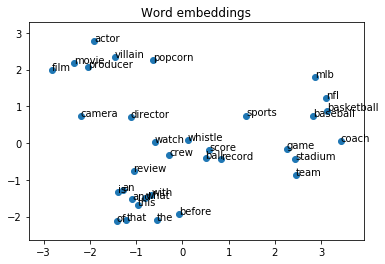

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
words_to_visualize = ['movie', 'film', 'watch', 'popcorn', 'director',
                     'the', 'and', 'of', 'what', 'that', 'baseball',
                     'mlb', 'nfl', 'sports', 'basketball', 
                      'actor', 'producer', 'villain', 'camera', 'review', 'game', 'whistle', 'stadium', 'team', 'coach', 'this',
                      'score', 'ball', 'is', 'an', 'with', 'before', 'crew', 'record']
vecs = []
for w in words_to_visualize:
    try:
        vecs.append(W[vocab[w]])
    except:
        print('%s does not exist in vocabulary :(' % w)    
    
small_W = np.array(vecs)
W_proj = PCA(n_components=2).fit_transform(small_W) # apply t-SNE

x = W_proj[:, 0] # first dimension
y = W_proj[:, 1] # second dimension

# plot the projected embeddings
plt.scatter(x, y)
plt.title('Word embeddings')

# set up axes to show all words 
plt.xlim(x.min()-0.5, x.max()+0.5)
plt.ylim(y.min()-0.5, y.max()+0.5)

# put text markers on plot
for w, x, y in zip(words_to_visualize, x, y):
        plt.annotate(w, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    


Your job is to play around with this function by choosing 15-20 different words to include in *words_to_visualize* and seeing if any meaningful clusters emerge in the resulting plot (or not!). After experimenting, pick one plot that demonstrates both *syntactic* and *semantic* similarity between words. Justify your choice by giving examples of each type of similarity from the plot.

**In the above plot, after adding some words we can see that there are a few clusters that have formed. Top-left consists of words that are semantically similar to film-related things; on the right consists of words which are semantically similar to sport-related things; while at the bottom consists the words that are common conjuctions and prepositions.**

**There also exist some words which are semantically ambiguous such as 'score'-which could mean the points in a game or the music of a film,'crew'- which could refer to the sport or workers on the set of a film, and 'record'- which could mean using the camera or achieving a milestone in a game.** 

**Some words which have syntactic and semantic similarity include 'team' and 'coach'- both of which can be a verb and a noun and also have a similar semantic relation to sports; and 'actor' & 'camera'- which are both singular nouns and have a strong relation to film.**